In [1]:
import h5py
import pickle
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers,models,optimizers,callbacks,constraints
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.layers import Input, LSTM,GRU,TimeDistributed,Dropout, RepeatVector, Dense, Conv2D,multiply,Lambda,Add,Concatenate, Multiply,Conv2DTranspose,Layer, Reshape, ZeroPadding2D,Flatten, MaxPool3D, UpSampling2D, BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,Callback,LearningRateScheduler,ModelCheckpoint
from sklearn.utils import shuffle
import math
import os
from tensorflow.keras import regularizers
from scipy.linalg import qr
tf.random.set_seed(46)
gpus = tf.config.list_physical_devices('GPU')
W=20
hdf5_file ='data/moreall_w20.hdf5'
hdf5 = h5py.File(hdf5_file, 'r')
N=0
hid_dim=5

number_list = list(np.arange(15))
train_idx=list(np.arange(45))
test_idx=[]

for i in range (3):
    w=i*15
    test_idx.append(np.array(random.sample(number_list,3))+w)
    
test_idx=np.array(test_idx).reshape(-1,1)

# for selected_value in test_idx:
#     train_idx.remove(selected_value)
# test_idx=list(test_idx.reshape(1,-1))

# np.save('train_label',train_idx)
# np.save('test_label',test_idx[0])

h5k=[list(hdf5.keys())[i] for i in train_idx]

for V in h5k:
    t=len(list(hdf5[V].keys())[:-1])
    N+=t
    
idx={i:[] for i in range (N)}

x=0



for V in h5k:
    
    n =list(hdf5[V].keys())[:-1]
    for fn in n:
        idx[x].append(V)
        idx[x].append(fn)
        
#         print(idx[x])
        x+=1

index=shuffle(idx)
# print(index)

def data_generator(idx, hdf5,batch_size,if_train = True):
    i = 0

    while True:
        X = []
        Y = []
        for b in range(batch_size):
            if i == len(idx):
                i = 0
            alll=idx[i]
            x = np.expand_dims(np.array(hdf5[alll[0]][alll[1]],dtype=np.float64),axis=-1)/255  # read dataset on the fly
#             x=np.rollaxis(x,1,0)
            x=np.nan_to_num(x)
            
            y_idx='trial_%04i' % int(int(alll[1][-4:])+1)
            y = np.expand_dims(np.array(hdf5[alll[0]][y_idx],dtype=np.float64),axis=-1)/255  # read dataset on the fly
#             y=np.rollaxis(y,1,0)
            y=np.nan_to_num(y)
            
            
            X.append(x)
            Y.append(y)
            i += 1

        X = np.asarray(X)
        Y = np.asarray(Y)
        
        
        yield [X,Y],[X,Y]

        
## input layer
class MSE_UNSUP(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(MSE_UNSUP, self).__init__(*args, **kwargs)
    def call(self,inputs):
        D,A=inputs

        L=tf.keras.losses.mse(D,A)
        L=tf.reduce_mean(L)
        self.add_loss(L*20*128*128, inputs=inputs)
        
        return inputs,L
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch =  -0.5 * K.sum(1 + log_var -
                                K.square(mu) - K.exp(log_var), axis=-1)

        self.add_loss(tf.reduce_mean(kl_batch), inputs=inputs)

        return inputs,tf.reduce_mean(kl_batch)

input0 = Input((W,128,128, 1))
input1 = Input((W,128,128, 1))


def encoder():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal"),input_shape = (W,128,128, 1)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Conv2D(16, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Conv2D(32, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Conv2D(32, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Conv2D(64, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())

    model.add(TimeDistributed(Flatten()))                           
#     model.summary()
    return model
encoder()
hidden=encoder()(input0)
encode=GRU(32)(hidden)                     

z_mu = Dense(hid_dim,kernel_regularizer='l1_l2')(encode)
z_log_var = Dense(hid_dim,kernel_regularizer='l1_l2')(encode)

[A, z_log_var_A2],loss3 = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma_A = Lambda(lambda t: K.exp(.5*t))(z_log_var_A2)

eps_A = K.random_normal(shape=(K.shape(input0)[0],hid_dim))
z_eps_A2 = Multiply()([z_sigma_A, eps_A])#Multiply()([z_sigma_A, eps_A])
z_A = Add()([A, z_eps_A2])

decode = RepeatVector(W)(z_A)
decode = GRU(32, return_sequences=True)(decode)
decode = GRU(hidden.shape[-1], return_sequences=True)(decode)

decode_future = RepeatVector(W)(z_A)
decode_future = GRU(32, return_sequences=True)(decode_future)
decode_future = GRU(hidden.shape[-1], return_sequences=True)(decode_future)

def decoder1():
    model1 = Sequential()
    model1.add(TimeDistributed(Reshape((4,4,64))))
    model1.add(TimeDistributed(Conv2DTranspose(32, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())
    model1.add(TimeDistributed(Conv2DTranspose(32, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())
    model1.add(TimeDistributed(Conv2DTranspose(16, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())

    model1.add(TimeDistributed(Conv2DTranspose(16, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())

    
    model1.add(TimeDistributed(Conv2DTranspose(1, (5,5), strides= (2,2),activation='sigmoid',padding='same', kernel_initializer="he_normal")))

    return model1

def decoder2():
    model1 = Sequential()
    model1.add(TimeDistributed(Reshape((4,4,64))))
    model1.add(TimeDistributed(Conv2DTranspose(32, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())
    model1.add(TimeDistributed(Conv2DTranspose(32, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())
    model1.add(TimeDistributed(Conv2DTranspose(16, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())

    model1.add(TimeDistributed(Conv2DTranspose(16, (5,5), strides= (2,2),padding='same', kernel_initializer="he_normal")))
    model1.add(LeakyReLU(alpha=0.05))
    model1.add(BatchNormalization())

    
    model1.add(TimeDistributed(Conv2DTranspose(1, (5,5), strides= (2,2),activation='sigmoid',padding='same', kernel_initializer="he_normal")))

    return model1
out1=decoder1()(decode)
out2=decoder2()(decode_future)

[out1,_],loss1=MSE_UNSUP()([out1,input0])
[out2,_],loss2=MSE_UNSUP()([out2,input1])



allmodel = Model(inputs=[input0,input1], outputs=[out1,out2])

allmodel.add_metric(loss3, "KL_loss")
allmodel.add_metric(loss2, "future_loss")

allmodel.add_metric(loss1, "current_loss")

allmodel.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0)
allmodel.compile( optimizer=optimizer,loss='mse')
bs=64

# history1 =allmodel.fit( data_generator(index,hdf5,bs,True),validation_data=data_generator(index[-1000:],hdf5, 10,False),
#                        batch_size=bs, epochs=100,validation_steps=np.ceil(1000/2-1),verbose=1, steps_per_epoch=np.ceil((len(idx))/300-1))
allmodel.load_weights("test_model_morelatent5_20.h5")
# allmodel.save_weights("split3_latent5_20.h5")



2023-01-13 13:46:48.930418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-01-13 13:46:59.182631: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-13 13:46:59.183620: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-13 13:46:59.183632: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-13 13:46:59.183656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c0703a-s15.ufhpc): /proc/driver/nvidia/version does not exist
2023-01-13 13:47:15.589448: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 128, 128 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 20, 1024)     97200       input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 32)           101568      sequential_1[0][0]               
__________________________________________________________________________________________________
dense (Dense)                   (None, 5)            165         gru[0][0]                        
______________________________________________________________________________________________

['N201',
 'N203',
 'N204',
 'N205',
 'N206',
 'N207',
 'N210',
 'N211',
 'N212',
 'N213',
 'N214',
 'N215',
 'N301',
 'N302',
 'N304',
 'N305',
 'N306',
 'N307',
 'N308',
 'N309',
 'N310',
 'N311',
 'N312',
 'N314',
 'N401',
 'N402',
 'N403',
 'N405',
 'N406',
 'N408',
 'N409',
 'N410',
 'N411',
 'N412',
 'N413',
 'N414']

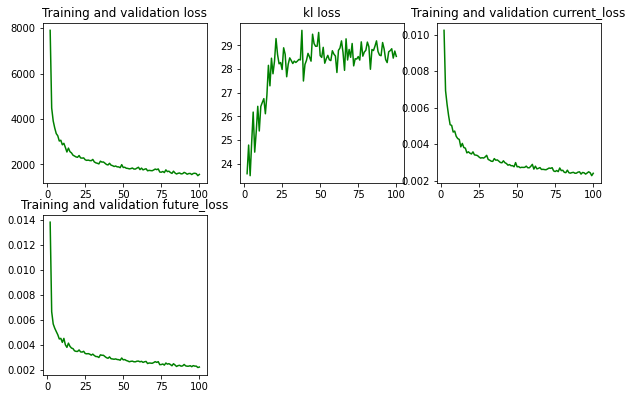

In [45]:
# allmodel.save_weights("model.h5")
# acc = history1.history['acc']
# val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(2, len(loss) + 1)

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

fig=plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
# plt.plot(epochs, loss[1:], 'r', label='Training loss')
plt.plot(epochs[:], val_loss[1:], 'g', label='Validation loss')
plt.title('Training and validation loss')
# plt.legend()
# plt.show()
###############################
loss1 = history1.history['KL_loss']
val_loss1 = history1.history['val_KL_loss']

# plt.figure(2)
plt.subplot(3,3,2)

# plt.plot(epochs, np.array(loss1)[1:]/(2*128*128), 'r', label='Training loss')
plt.plot(epochs[:], np.array(val_loss1)[1:], 'g', label='Validation loss')
plt.title('kl loss')
# plt.legend()

# plt.show()

###############################
loss2 = history1.history['current_loss']
val_loss2 = history1.history['val_current_loss']

# plt.figure(3)
plt.subplot(3,3,3)

# plt.plot(epochs, np.array(loss2)[1:]/(500), 'r', label='Training loss')
plt.plot(epochs, np.array(val_loss2)[1:], 'g', label='Validation loss')
plt.title('Training and validation current_loss')
# plt.legend()

# plt.show()
###############################
loss3 = history1.history['future_loss']
val_loss3 = history1.history['val_future_loss']

# plt.figure(3)
plt.subplot(3,3,4)

# plt.plot(epochs, np.array(loss3)[1:]/(1000), 'r', label='Training loss')
plt.plot(epochs, np.array(val_loss3)[1:], 'g', label='Validation loss')
plt.title('Training and validation future_loss')
# plt.legend()

plt.savefig("im_human_helf.pdf",dpi=fig.dpi)

In [35]:
hdf5.keys()

<KeysViewHDF5 ['N201', 'N202', 'N203', 'N204', 'N205', 'N206', 'N207', 'N208', 'N209', 'N210', 'N211', 'N212', 'N213', 'N214', 'N215', 'N301', 'N302', 'N303', 'N304', 'N305', 'N306', 'N307', 'N308', 'N309', 'N310', 'N311', 'N312', 'N313', 'N314', 'N315', 'N401', 'N402', 'N403', 'N404', 'N405', 'N406', 'N407', 'N408', 'N409', 'N410', 'N411', 'N412', 'N413', 'N414', 'N415']>

In [63]:
intermediate_layer_model = Model(inputs=allmodel.input,
                                 outputs=allmodel.output)###41 latent 42 label 43 image
intermediate_layer_model.summary()
imageout1=np.zeros((8,W,128,128,1))
imageout2=np.zeros((8,W,128,128,1))

laaa=np.zeros((8,W,128,128,1))
laaa1=np.zeros((8,W,128,128,1))





idx={i:[] for i in range (8)}
z=0
video=['N201','N404']
trails=['trial_0027', 'trial_0127', 'trial_0227', 'trial_0800']


for j in video:
    for k in trails:
        idx[z].append(j)
        idx[z].append(k)

        z+=1

z=0
ind=idx

for alp in range (8):
    alll=ind[alp]
    
    x = np.expand_dims(np.array(hdf5[alll[0]][alll[1]],dtype=np.float64),axis=-1)/255  # read dataset on the fly
    x=np.expand_dims(x,axis=0)
    
    y_idx='trial_%04i' % int(int(alll[1][-4:])+1)
    y = np.expand_dims(np.array(hdf5[alll[0]][y_idx],dtype=np.float64),axis=-1)/255  # read dataset on the fly
    y=np.expand_dims(y,axis=0)
    
    intermediate_output1,intermediate_output2 = intermediate_layer_model.predict([x,y])#
    imageout1[z]=intermediate_output1
    imageout2[z]=intermediate_output2
    laaa[z,:]=x
    laaa1[z,:]=y
    

    z+=1

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 20, 128, 128 0                                            
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 20, 1024)     97200       input_13[0][0]                   
__________________________________________________________________________________________________
gru_30 (GRU)                    (None, 32)           101568      sequential_25[0][0]              
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 5)            165         gru_30[0][0]                     
___________________________________________________________________________________________

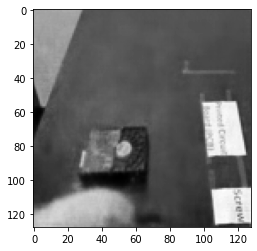

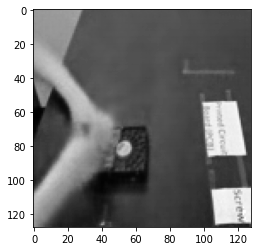

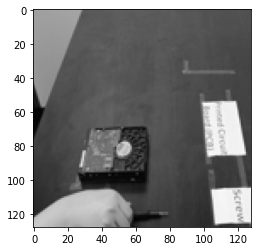

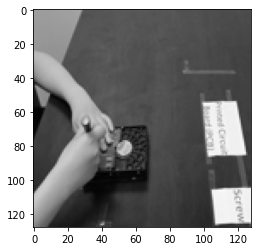

In [66]:


from matplotlib.pyplot import cm
plt.imshow(imageout1[0,W-1],cmap=cm.gray)
plt.show ()
plt.imshow(imageout2[6,W-1],cmap=cm.gray)
plt.show ()
plt.imshow(laaa[0,W-1],cmap=cm.gray)
plt.show ()
plt.imshow(laaa1[6,W-1],cmap=cm.gray)

plt.show ()


In [41]:
intermediate_layer_model = Model(inputs=allmodel.input,outputs=allmodel.layers[11].output)
intermediate_layer_model.summary()

hdf5_file ='data/moreall_w20.hdf5'
hdf5 = h5py.File(hdf5_file, 'r')
N=0
hid_dim=5
# for V in list(hdf5.keys()):
#     t=len(list(hdf5[V].keys())[:-1])
#     N+=t
    
# idx={i:[] for i in range (N)}

for V in list(hdf5.keys())[:]:
    x=0
    
    n =list(hdf5[V].keys())[:-1]
    t=len(n)
    idx={i:[] for i in range (t)}
    print(V)
    for fn in n:
        idx[x].append(V)
        idx[x].append(fn)
        
#         print(idx[x])
        x+=1

    ind=idx
    L=np.zeros((len(ind),5))
    I=np.zeros((len(ind),W,128,128,1))
    Iy=np.zeros((len(ind),W,128,128,1))
    
    
    
    
    z=0
    for alp in range (len(ind)):
        alll=ind[alp]

        x = np.expand_dims(np.array(hdf5[alll[0]][alll[1]],dtype=np.float64),axis=-1)/255  # read dataset on the fly
        x=np.expand_dims(x,axis=0)
        
        y_idx='trial_%04i' % int(int(alll[1][-4:])+1)
        y = np.expand_dims(np.array(hdf5[alll[0]][y_idx],dtype=np.float64),axis=-1)/255  # read dataset on the fly
        y=np.expand_dims(y,axis=0)

        latent = intermediate_layer_model.predict([x,y])#
        L[z]=latent
        I[z]=x
        Iy[z]=y
        
        

        z+=1
    np.save('latent_traversal_20_'+V,L)
    np.save('latent_traversalimagecurrent_20_'+V,I)
    np.save('latent_traversalimagefuture_20_'+V,Iy)
    
#     np.save('image_30_'+V,I)
    
###40 label predict, 41 image####40 back ####42

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 20, 128, 128 0                                            
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 20, 1024)     97200       input_13[0][0]                   
__________________________________________________________________________________________________
gru_30 (GRU)                    (None, 32)           101568      sequential_25[0][0]              
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 5)            165         gru_30[0][0]                     
___________________________________________________________________________________________

KeyboardInterrupt: 

In [31]:
np.load('latent_traversalimagecurrent_20_N205.npy').shape

(824, 20, 128, 128, 1)

In [36]:
allmodel.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 20, 128, 128 0                                            
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 20, 1024)     97200       input_13[0][0]                   
__________________________________________________________________________________________________
gru_30 (GRU)                    (None, 32)           101568      sequential_25[0][0]              
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 5)            165         gru_30[0][0]                     
___________________________________________________________________________________________

In [42]:
latentall=np.load('all_latent5_20.npy')

[<KerasTensor: shape=(None, 20, 128, 128, 1) dtype=float32 (created by layer 'mse_unsup_12')>, <KerasTensor: shape=(None, 20, 128, 128, 1) dtype=float32 (created by layer 'mse_unsup_12')>]
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
repeat_vector_12 (RepeatVector) (None, 20, 5)        0           input_22[0][0]                   
__________________________________________________________________________________________________
gru_31 (GRU)                    (None, 20, 32)       3744        repeat_vector_12[8][0]           
__________________________________________________________________________________________________
g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 500 is out of bounds for axis 0 with size 8

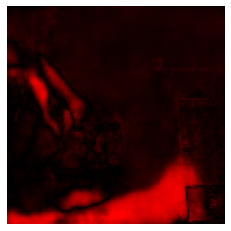

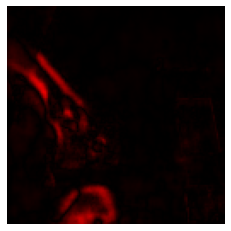

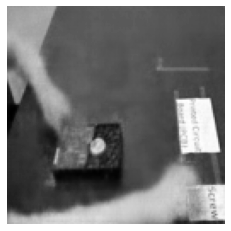

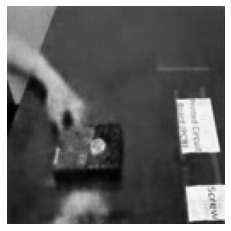

<Figure size 432x288 with 0 Axes>

In [43]:
import cv2
###########1,6,10,14
input1 = Input(shape=(W,128,128,1), name="current")
input2 = Input(shape=(W,128,128,1), name="future")

latentinput=Input(5)

x=allmodel.layers[12](latentinput)#43
x=allmodel.layers[14](x)#43
x=allmodel.layers[16](x)#43
x=allmodel.layers[18](x)#43


x,_=allmodel.layers[21]([x,input1])#46
print(x)

new_model = Model([latentinput,input1], x)
tt=180
new_model.summary()
NNN=10
import os

path='./new_paper2/'
# os.mkdir(path)
import matplotlib.cm as cm     
from sklearn import preprocessing
import pandas as pd
for j in range (5):

    latent=np.load('latent_traversal_20_N205.npy')
    laaa1=np.load('latent_traversalimagecurrent_20_N205.npy')
    laaa2=np.load('latent_traversalimagefuture_20_N205.npy')

    maxv=np.max(latentall[:,j])
    minv=np.min(latentall[:,j])
    
#     ran=np.arange(minv,maxv,0.1)
#     changed_latent=np.zeros((len(ran),128,128,2))


#     for i in range (len(ran)):
    latent[500,j]=minv
    output2,_ = new_model.predict([latent[:,:],laaa1])
    latent[500,j]=(maxv+minv)/2
    output3,_ = new_model.predict([latent[:,:],laaa1])
    latent[500,j]=maxv
    output,_ = new_model.predict([latent[:,:],laaa1])
    
    v=output[500,-1,:,:,0]-output2[500,-1,:,:,0]
    v=np.abs(v)
    v=cv2.merge([v*1.5,v*0,v*0])
    
    
    v2=output[500,-1,:,:,0]-output3[500,-1,:,:,0]#np.concatenate((output[189*NNN+tt,:,:,0].T,output[189*NNN+tt,:,:,1].T),axis=1)-np.concatenate((output3[189*NNN+tt,:,:,0].T,output3[189*NNN+tt,:,:,1].T),axis=1)
    v2=np.abs(v2)
    v2=cv2.merge([v2*1.5,v2*0,v2*0])
    


    
    plt.figure(1)
#     plt.imshow(v,vmin = -tt, vmax = tt,cmap=plt.get_cmap('gray'))
    plt.imshow(v,vmin =np.percentile(v, 1), vmax =1,cmap=plt.get_cmap('gray'))

    plt.axis('off')
    plt.savefig(path+"variance_final_"+str(j)+".png",bbox_inches='tight', pad_inches = 0.05)
    plt.figure(2)
#     plt.imshow(v2,vmin = -tt2, vmax = tt2,cmap=plt.get_cmap('gray'))
    plt.imshow(v2,vmin =np.percentile(v2, 1), vmax =1,cmap=plt.get_cmap('gray'))

    plt.axis('off')
    plt.savefig(path+"variance_helf_"+str(j)+".png",bbox_inches='tight', pad_inches = 0.05)
    plt.figure(3)
    plt.imshow(output2[500,-1],cmap=cm.gray)
    plt.axis('off')
    plt.savefig(path+"final_"+str(j)+".png",bbox_inches='tight', pad_inches = 0.05)
    plt.figure(4)
    plt.imshow(output[500,-1],cmap=cm.gray)
    plt.axis('off')
    plt.savefig(path+"helf_"+str(j)+".png",bbox_inches='tight', pad_inches = 0.05)
    
    
    
    
plt.figure(5)
plt.imshow(laaa[500,-1],cmap=cm.gray)
plt.axis('off')
plt.savefig(path+mice+"org.png",bbox_inches='tight', pad_inches = 0.05)

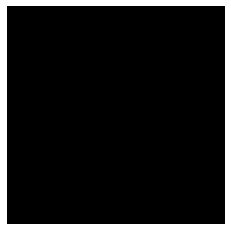

In [49]:
plt.figure(5)
plt.imshow(np.zeros((128,128))*1,vmin=0,vmax=0.8,cmap=cm.gray)
plt.axis('off')

plt.savefig(path+"black_bg",bbox_inches='tight', pad_inches = 0.05)

In [60]:
def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])
path='./new_paper2/'
# for m in mouse:
ID=4
bk=cv2.imread(path+'black_bg.png')

org1=cv2.imread(path+'org.png')
im1a=cv2.imread(path+'helf_'+str(ID)+'.png')
im2a=cv2.imread(path+'final_'+str(ID)+'.png')
im1=cv2.imread(path+'variance_helf_'+str(ID)+'.png')
im2=cv2.imread(path+'variance_final_'+str(ID)+'.png')


# im1

im_tile = concat_tile([[org1,im1a,im2a],
    [bk,im1,im2]])


cv2.imwrite(path+str(ID)+'allll.jpg', im_tile)


True

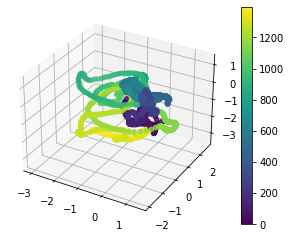

In [21]:
L1=np.load('latenttest5_20_N402.npy')
L1=stats.zscore(L1, axis=0, ddof=1)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L1[:,1],L1[:,0],L1[:,2],c=np.arange(len(L1)))
p=ax.scatter(L1[:,1],L1[:,0],L1[:,2],c=np.arange(len(L1)))

fig.colorbar(p)

# ax.plot(L1[:3,1],L1[:3,0],L1[:3,2])
# ax.plot(L1[3:53,1],L1[3:53,0],L1[3:53,2])
# ax.plot(L1[53:301,1],L1[53:301,0],L1[53:301,2])
# ax.plot(L1[301:405,1],L1[301:405,0],L1[301:405,2])
# ax.plot(L1[405:446,1],L1[405:446,0],L1[405:446,2])######
# ax.plot(L1[446:479,1],L1[446:479,0],L1[446:479,2])
# ax.plot(L1[479:556,1],L1[479:556,0],L1[479:556,2])######
# ax.plot(L1[556:594,1],L1[556:594,0],L1[556:594,2])######
# ax.plot(L1[594:623,1],L1[594:623,0],L1[594:623,2])######
# ax.plot(L1[623:655,1],L1[623:655,0],L1[623:655,2])######
# ax.plot(L1[655:706,1],L1[655:706,0],L1[655:706,2])######
# ax.plot(L1[706:,1],L1[706:,0],L1[706:,2])######



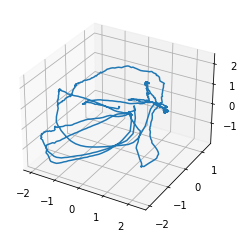

In [9]:
L1=np.load('more_latent_30_N201.npy')
L1=stats.zscore(L1, axis=0, ddof=1)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(L1[:,1],L1[:,0],L1[:,2])


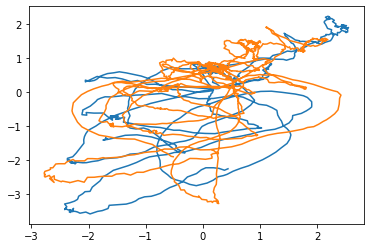

In [51]:
L1=np.load('more_latent6more_20_N203.npy')
L2=np.load('more_latent6more_20_N403.npy')

# L1=stats.zscore(L1, axis=0, ddof=1)
from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
plt.plot(L1[:,0],L1[:,2])
plt.plot(L2[:,0],L2[:,2])



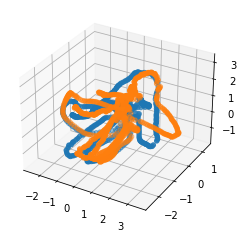

In [11]:
L1=np.load('more_latent_30_N207.npy')
L1=stats.zscore(L1, axis=0, ddof=1)

L2=np.load('more_latent_30_N308.npy')
L2=stats.zscore(L2, axis=0, ddof=1)

L3=np.load('more_latent_30_N210.npy')
L3=stats.zscore(L3, axis=0, ddof=1)



from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L1[:,1],L1[:,0],L1[:,2])
# ax.scatter(L1[0,1],L1[0,0],L1[0,2])
# ax.scatter(L1[-1,1],L1[-1,0],L1[-1,2])

ax.scatter(L2[:,1],L2[:,0],L2[:,2])
# ax.scatter(L3[:,1],L3[:,0],L3[:,2])




In [12]:
for V in list(hdf5.keys())[:]:
#     print(V)
    L=np.load('more_latent_30_'+V+'.npy')
    L=L/np.max(L,axis=0)
    print(L.shape)
    ALL=np.concatenate((ALL,L),axis=0)
    plt.scatter(L[:,0],L[:,1],alpha=0.1)

(903, 3)


NameError: name 'ALL' is not defined

In [13]:
hdf5.keys()

<KeysViewHDF5 ['N201', 'N202', 'N203', 'N204', 'N205', 'N206', 'N207', 'N208', 'N209', 'N210', 'N211', 'N212', 'N213', 'N214', 'N215', 'N301', 'N302', 'N303', 'N304', 'N305', 'N306', 'N307', 'N308', 'N309', 'N310', 'N311', 'N312', 'N313', 'N314', 'N315', 'N401', 'N402', 'N403', 'N404', 'N405', 'N406', 'N407', 'N408', 'N409', 'N410', 'N411', 'N412', 'N413', 'N414', 'N415']>

(775, 5)
(726, 5)
(799, 5)
(824, 5)
(801, 5)
(857, 5)
(973, 5)
(970, 5)
(937, 5)
(938, 5)
(898, 5)
(930, 5)
(912, 5)
(917, 5)
(1133, 5)
(1288, 5)
(1153, 5)
(1107, 5)
(1150, 5)
(1113, 5)
(1119, 5)
(1178, 5)
(1055, 5)
(1210, 5)
(1067, 5)
(1024, 5)
(1072, 5)
(1080, 5)
(1129, 5)
(1297, 5)
(1396, 5)
(1291, 5)
(1266, 5)
(1241, 5)
(1217, 5)
(1223, 5)
(1285, 5)
(1236, 5)
(1213, 5)
(1286, 5)
(1071, 5)
(1372, 5)
(1214, 5)
(1243, 5)


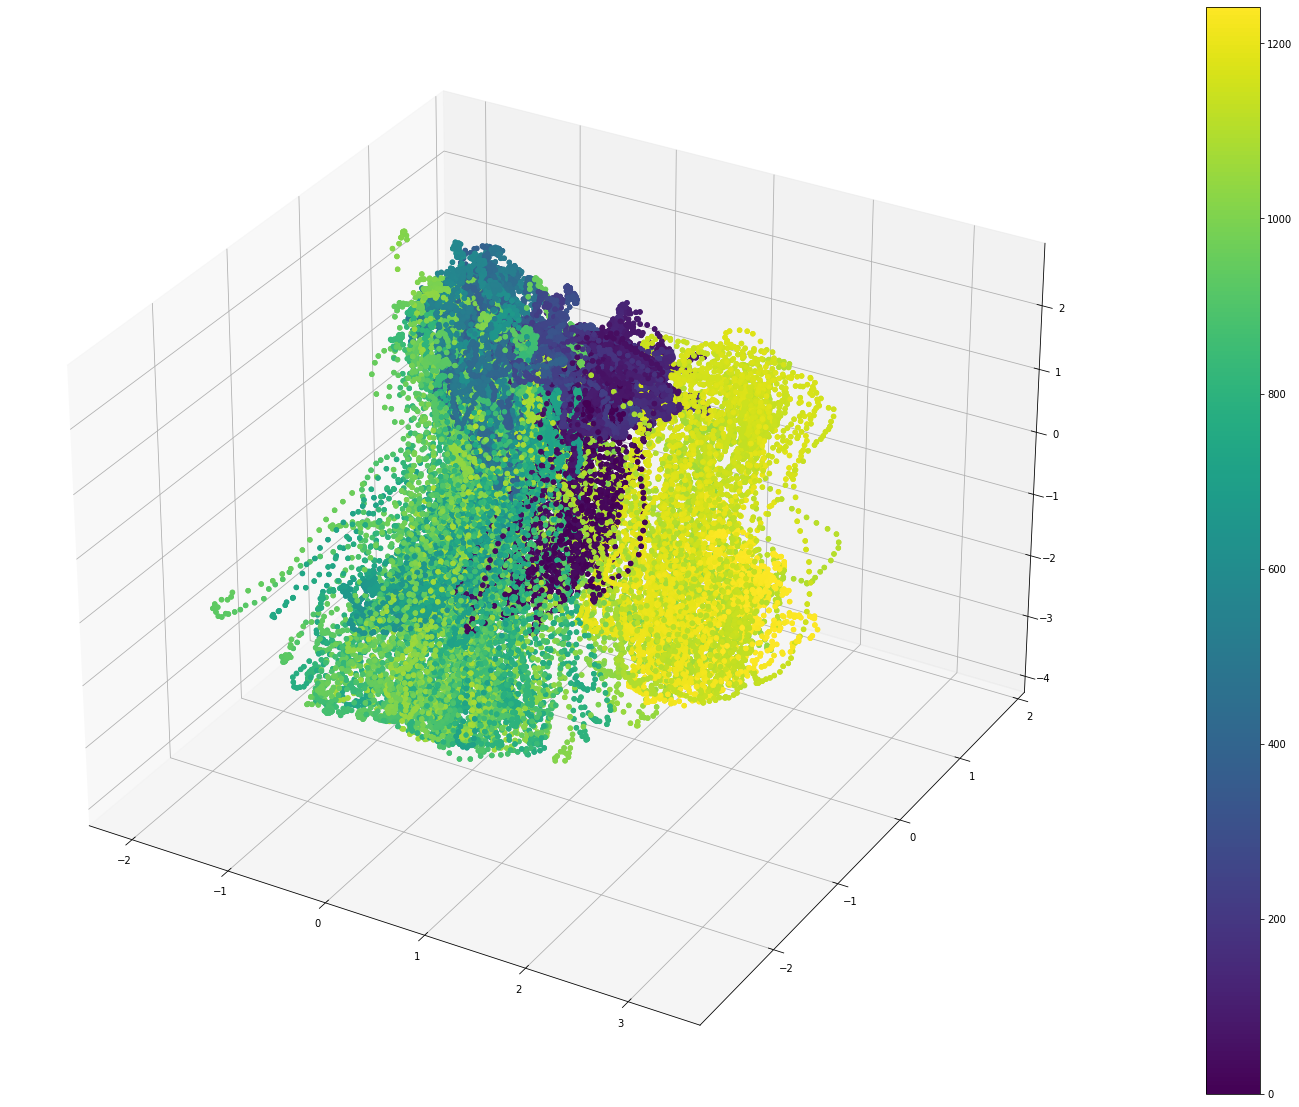

In [25]:
ALL=np.load('2latenttest5_20_'+'N201'+'.npy')
ALL=stats.zscore(ALL, axis=0, ddof=1)

from scipy import stats


fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(ALL[:,0],ALL[:,1],ALL[:,2],alpha=1)
Li=[list(hdf5.keys())[31],list(hdf5.keys())[32],list(hdf5.keys())[33]]
for V in list(hdf5.keys())[1:]:
#     print(V)
    L=np.load('2latenttest5_20_'+V+'.npy')
    L=stats.zscore(L, axis=0, ddof=1)
    
    print(L.shape)
    ALL=np.concatenate((ALL,L),axis=0)
#     ax.scatter(L[:,0],L[:,1],L[:,2],alpha=1)
    
    ax.scatter(L[:,0],L[:,1],L[:,2],alpha=1,c=np.arange(len(L)),cmap='viridis')
    p=ax.scatter(L[:,0],L[:,1],L[:,2],alpha=1,c=np.arange(len(L)),cmap='viridis')
#     fig.colorbar(p)
#     plt.title(V)
#     plt.scatter(L[:,0],L[:,1])
#     plt.show()
#     ax.show()
fig.colorbar(p)

# plt.savefig('time_various.pdf')

np.save('2new5_20',ALL)

In [107]:
L.shape,ALL.shape

((48899, 3), (48899, 3))

(775, 128, 128, 1)
(726, 128, 128, 1)
(799, 128, 128, 1)
(824, 128, 128, 1)
(801, 128, 128, 1)
(857, 128, 128, 1)
(973, 128, 128, 1)
(970, 128, 128, 1)
(937, 128, 128, 1)
(938, 128, 128, 1)
(898, 128, 128, 1)
(930, 128, 128, 1)
(912, 128, 128, 1)
(917, 128, 128, 1)
(1133, 128, 128, 1)
(1288, 128, 128, 1)
(1153, 128, 128, 1)
(1107, 128, 128, 1)
(1150, 128, 128, 1)
(1113, 128, 128, 1)
(1119, 128, 128, 1)
(1178, 128, 128, 1)
(1055, 128, 128, 1)
(1210, 128, 128, 1)
(1067, 128, 128, 1)
(1024, 128, 128, 1)
(1072, 128, 128, 1)
(1080, 128, 128, 1)
(1129, 128, 128, 1)
(1297, 128, 128, 1)
(1396, 128, 128, 1)
(1291, 128, 128, 1)
(1266, 128, 128, 1)
(1241, 128, 128, 1)
(1217, 128, 128, 1)
(1223, 128, 128, 1)
(1285, 128, 128, 1)
(1236, 128, 128, 1)
(1213, 128, 128, 1)
(1286, 128, 128, 1)
(1071, 128, 128, 1)
(1372, 128, 128, 1)
(1214, 128, 128, 1)
(1243, 128, 128, 1)


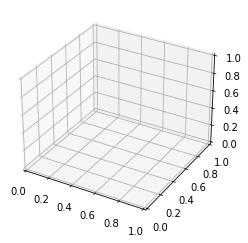

In [41]:
Leng=[]
ALL=np.load('image_20/image_20_'+'N201'+'.npy')
from scipy import stats
Leng.append(len(ALL))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(ALL[:,0],ALL[:,1],ALL[:,2],alpha=1)

for V in list(hdf5.keys())[1:]:
#     print(V)
    L=np.load('image_20/image_20_'+V+'.npy')
#     L=stats.zscore(L, axis=0, ddof=1)
    print(L.shape)
    Leng.append(len(L))
    
    ALL=np.concatenate((ALL,L),axis=0)
#     ax.scatter(L[:,0],L[:,1],L[:,2],alpha=1)
#     plt.title(V)
#     plt.scatter(L[:,0],L[:,1])
#     plt.show()
#     ax.show()
np.save('allimage_20',ALL)

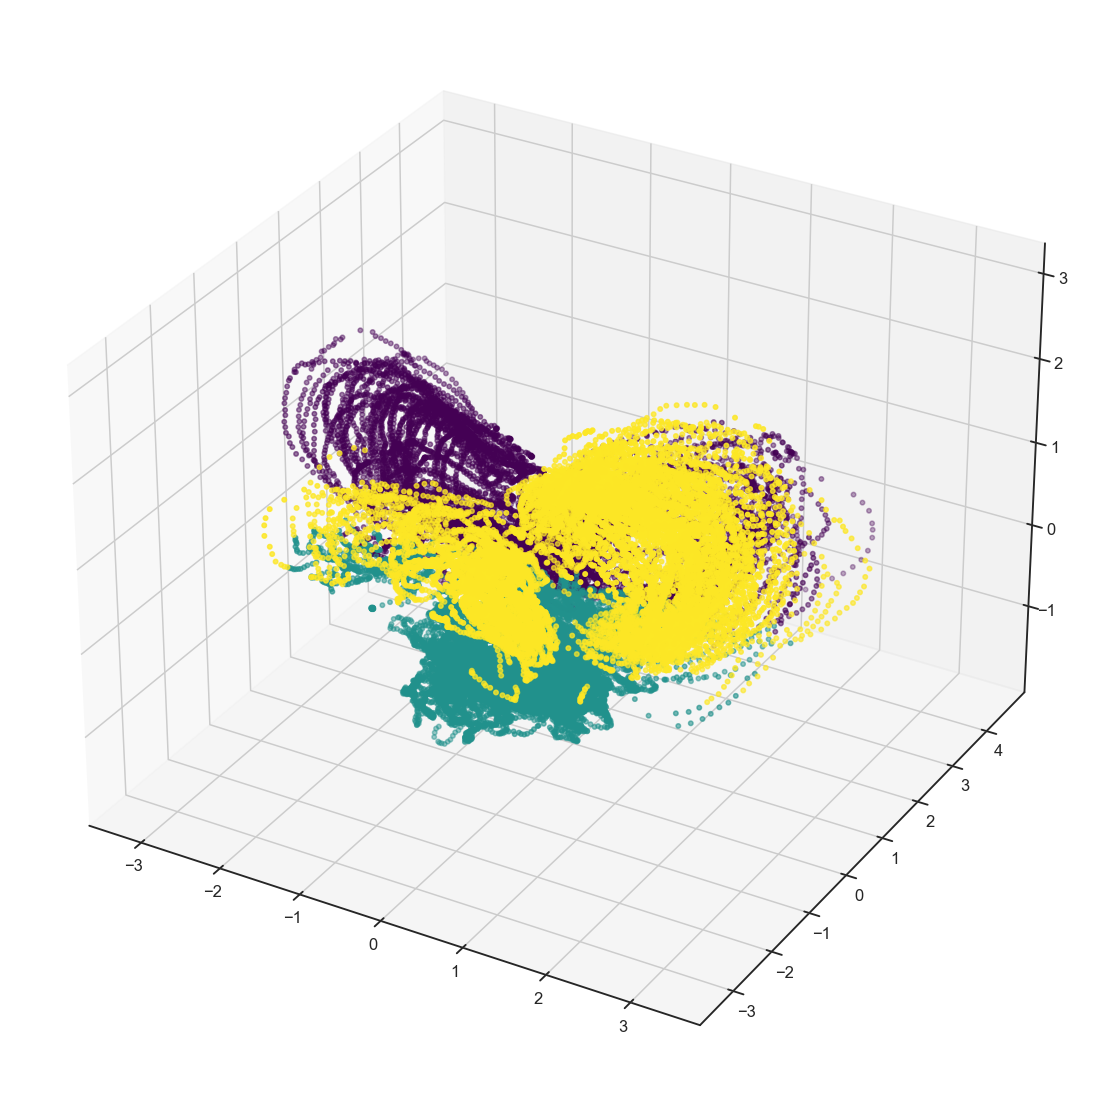

In [212]:
state=np.load('sh.npy')
L=np.array(np.load('allmore_latent_20.npy'),dtype='float64')
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L[:,0],L[:,1],L[:,2],c=state,cmap='viridis')
plt.savefig('Kmeans.pdf')


In [43]:
from sklearn.cluster import KMeans
L=np.array(np.load('allmore_latent_20.npy'),dtype='float64')

num_states=3
# kmeans = KMeans(n_clusters=num_states, random_state=46).fit_predict(L)
# np.save('sh.npy',kmeans)
Leng=np.load('leng.npy')
###########make video
import numpy as np
import matplotlib.pyplot as plt
import os
laaa=np.load('allimage_20.npy')
state=np.load('00.npy')
for III in range (6):

    state0=np.where(state==III)
#     state1=np.where(state==1)
#     state2=np.where(state==2)

    import numpy as np
    import cv2
    import pickle
    # initialize water image
    height = 128
    width = 128
    # water_depth = np.zeros((height, width), dtype=float)

    # initialize video writer
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    fps = 30
    #29 209 300
    video_filename = 'f2-states'+str(III)+'.avi'#8,9,12,13,14
    out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

    # new frame after each addition of water
    # for j in range (300,301):
    for i in np.array(state0)[0]:

        array=laaa[int(i),:,:,0]#,allow_pickle=True)

        gray = cv2.normalize(array, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        gray_3c = cv2.merge([gray, gray, gray])
        out.write(gray_3c)

    # close out the video writer
    out.release()


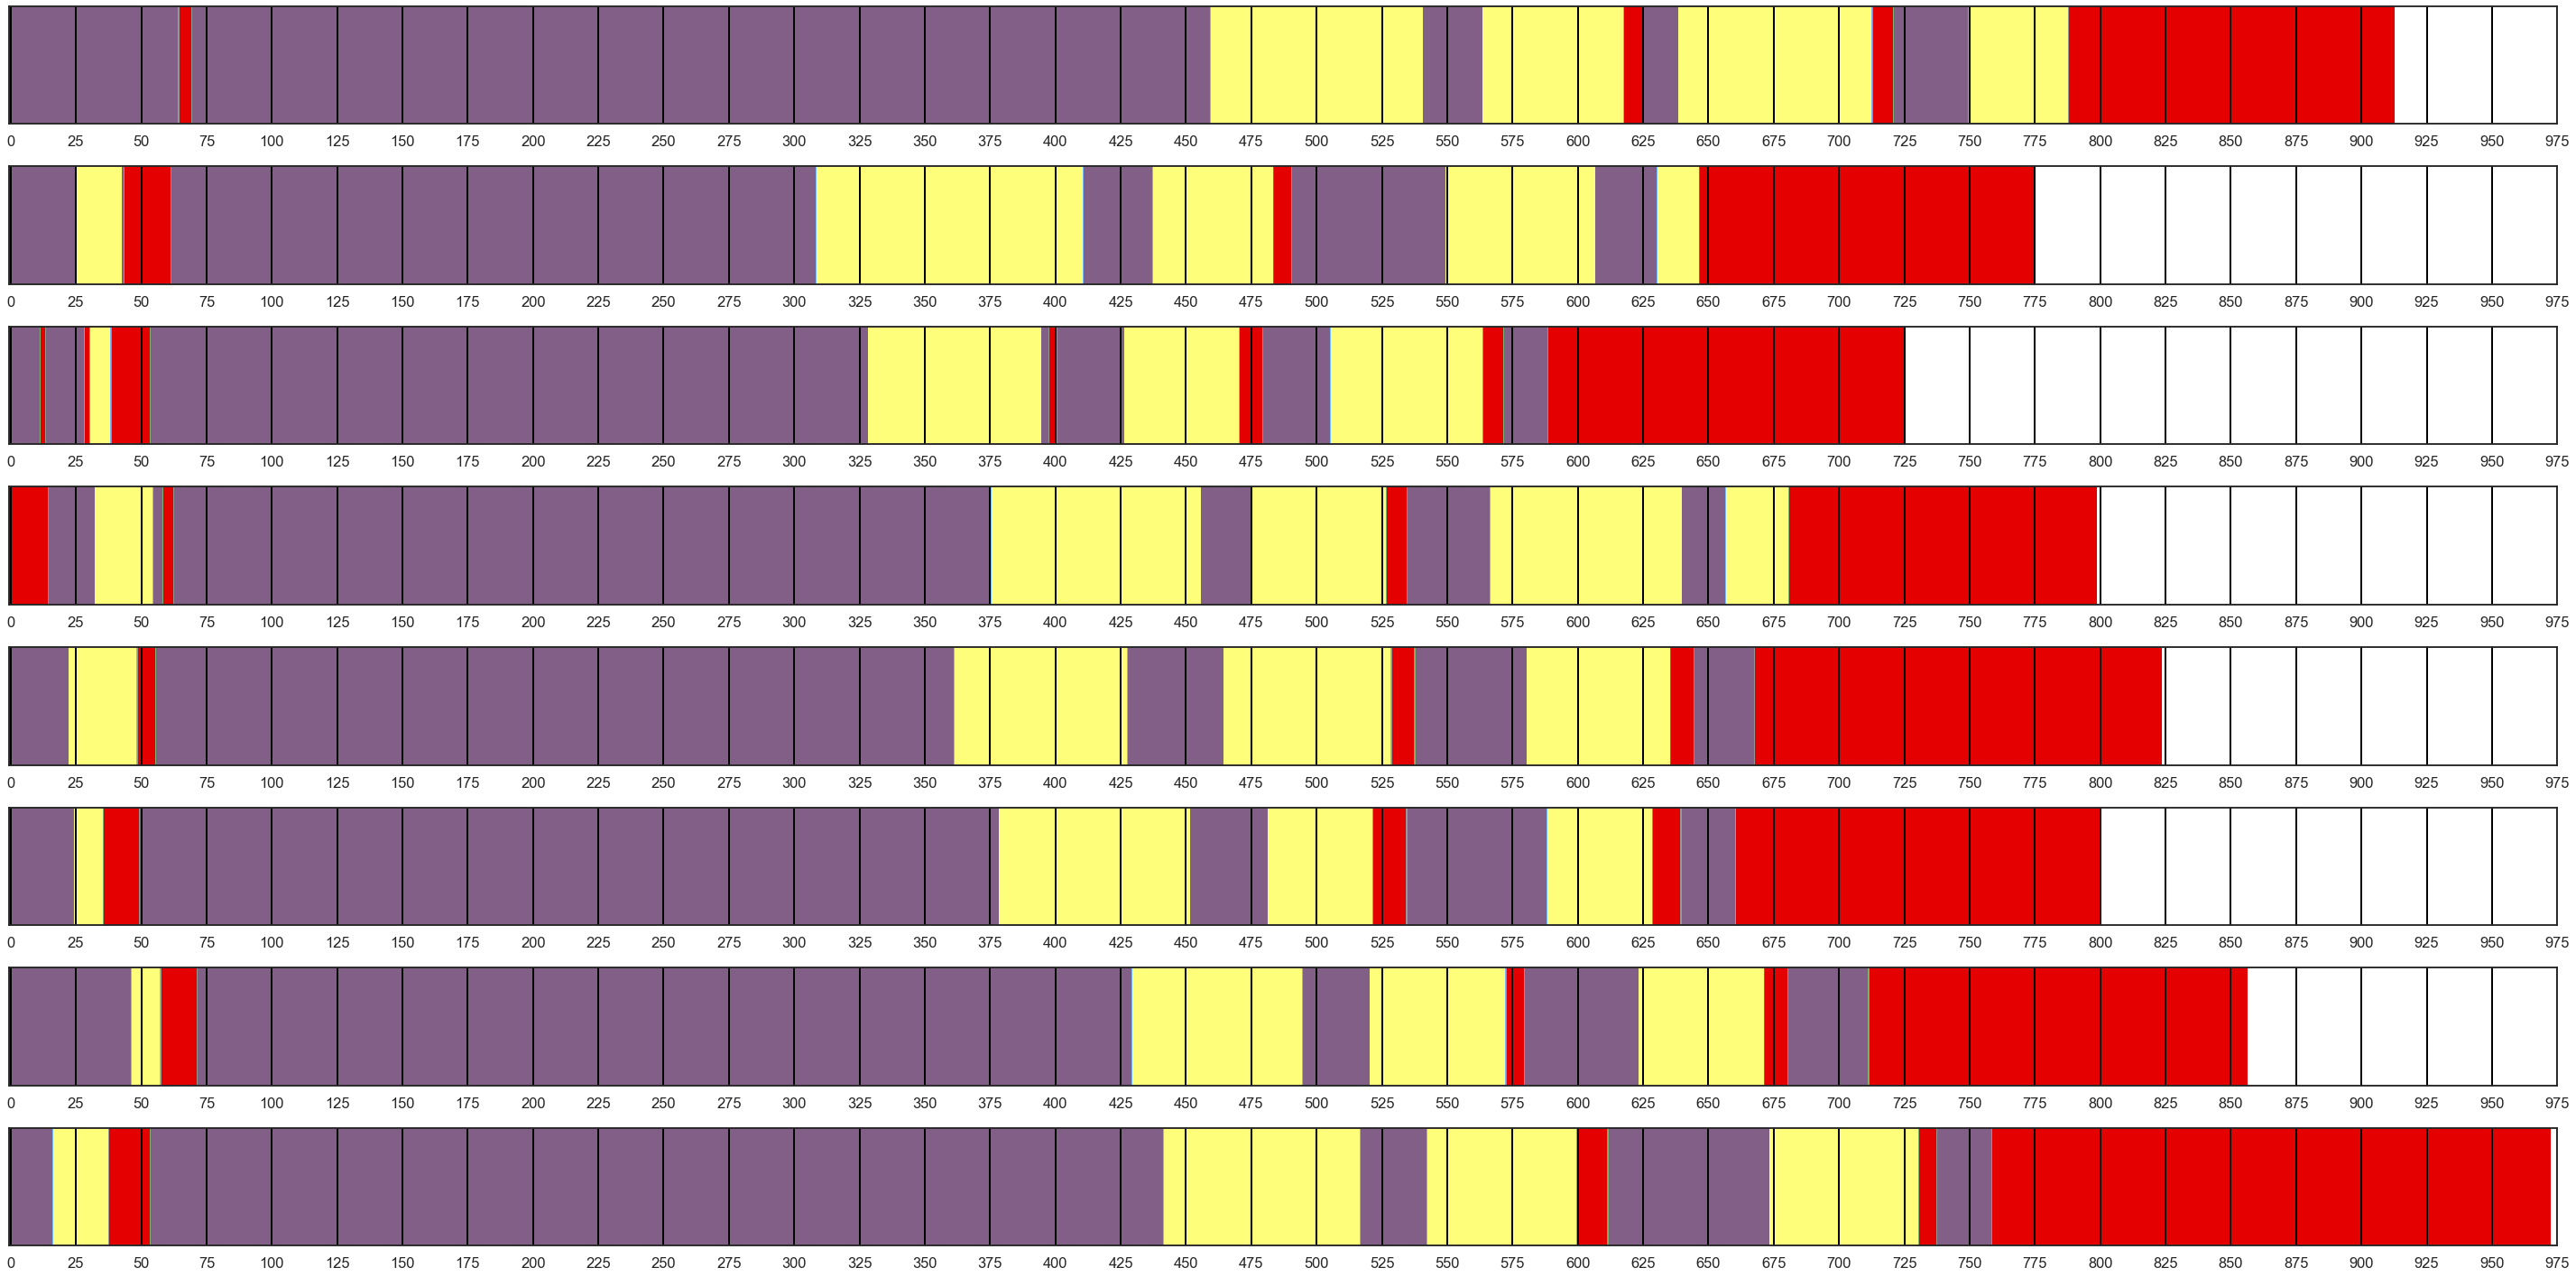

In [200]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
import os
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = [#"windows blue",
               "red",
               "grey",
               "faded green",
               "dusty purple",
#                "navajowhite",
    "sky blue",
#                "clay",
#                "pink",
#                "greyish",
#                "mint",
#                "cyan",
#                "steel blue",
#                "forest green",
    "light yellow",
#                "pastel purple",
               "light yellow",
               ]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)
cmap_limited = ListedColormap(colors[0:num_states])
NNN=8
Leng=np.load('leng.npy')
kmeans=np.load('sh.npy')
q_lem_z=kmeans
# states_list=[q_lem_z[:100],q_lem_z[100:200],q_lem_z[200:300],q_lem_z[300:400],q_lem_z[400:500],q_lem_z[500:600],q_lem_z[600:700],q_lem_z[800:900]]
states_list=[q_lem_z[:Leng[0]],q_lem_z[Leng[0]:Leng[1]+Leng[0]],q_lem_z[Leng[1]+Leng[0]:Leng[1]+Leng[0]+Leng[2]],q_lem_z[Leng[1]+Leng[0]+Leng[2]:Leng[1]+Leng[0]+Leng[2]+Leng[3]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]],q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]+Leng[7]]]

x = np.arange(0,1000,1) # the grid to which your data corresponds
nx = x.shape[0]
no_labels = 40 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = x[::step_x] # labels you want to see

fig, axs = plt.subplots(8,1, figsize=(40,20))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_xticks(x_positions)
#     ax.set_xticks([])

    ax.grid(color='k', linestyle='-', linewidth=2)
#     ax.set_title(titles[i])
#     if i < (len(axs) - 1):
#         ax.set_xticks([])

# plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()


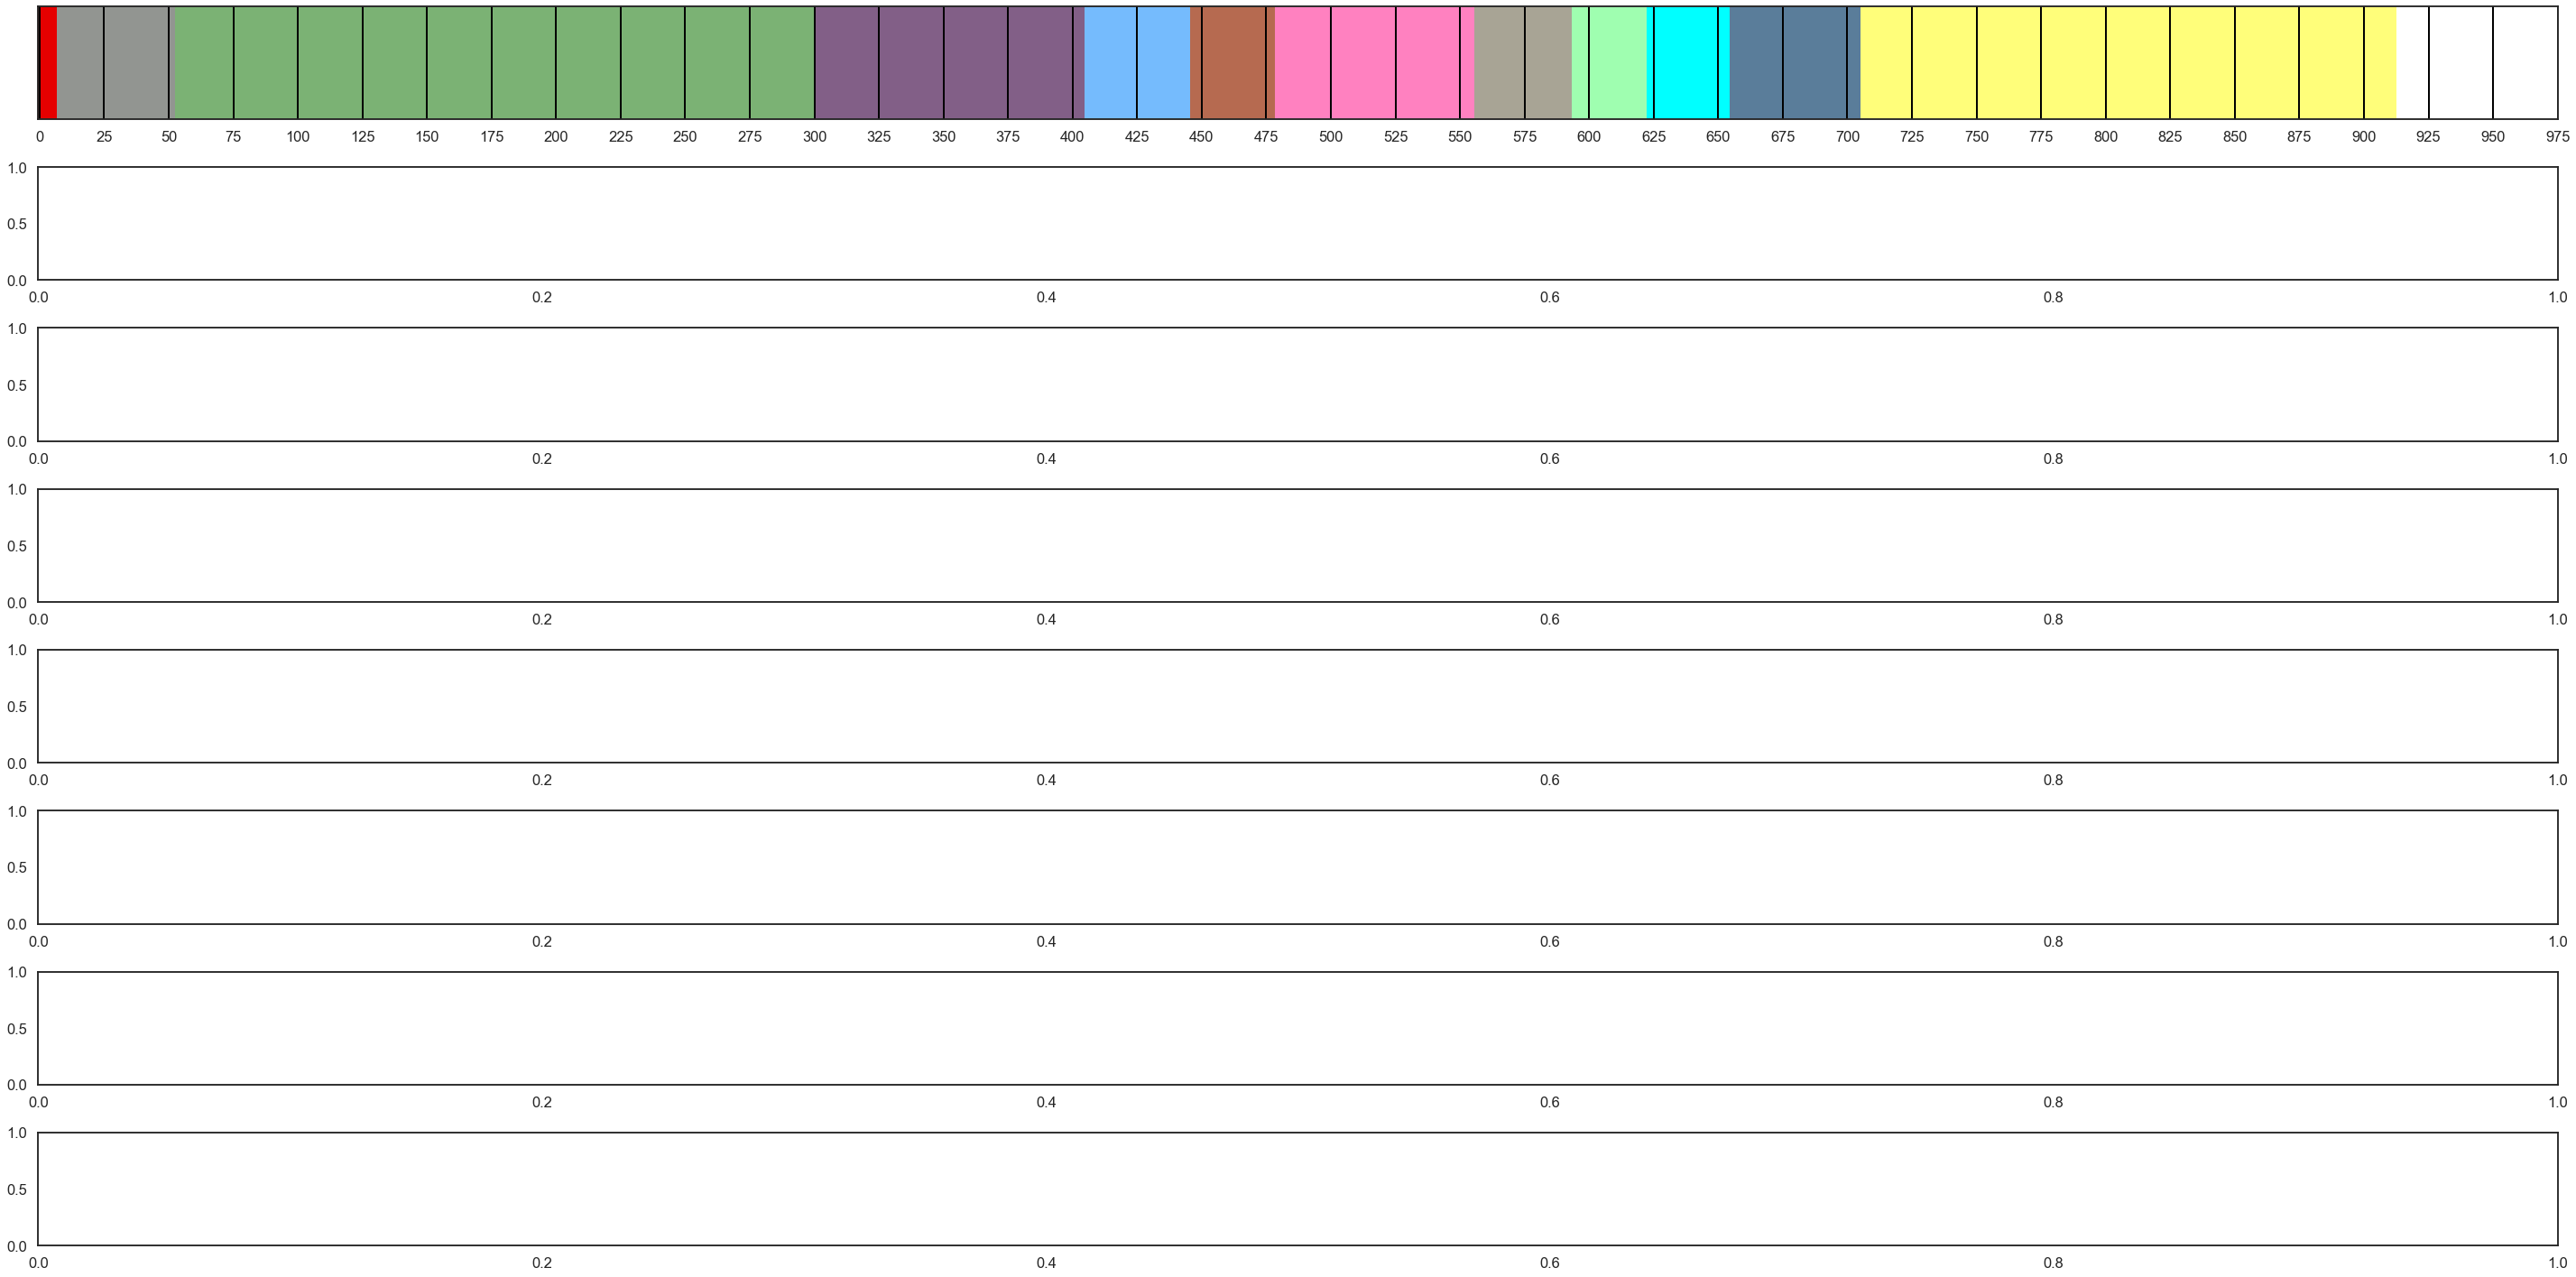

In [198]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
import os
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = [#"windows blue",
               "red",
               "grey",
               "faded green",
               "dusty purple",
#                "navajowhite",
    "sky blue",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
#                "forest green",
    "light yellow",
#                "pastel purple",
               "light yellow",
               ]


num_states=12
colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)
cmap_limited = ListedColormap(colors[0:num_states])
NNN=8
Leng=np.load('leng.npy')
kmeans=SS#np.load('sh.npy')

q_lem_z=kmeans[:]

# states_list=[q_lem_z[:100],q_lem_z[100:200],q_lem_z[200:300],q_lem_z[300:400],q_lem_z[400:500],q_lem_z[500:600],q_lem_z[600:700],q_lem_z[800:900]]
states_list=[q_lem_z]

x = np.arange(0,1000,1) # the grid to which your data corresponds
nx = x.shape[0]
no_labels = 40 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = x[::step_x] # labels you want to see

fig, axs = plt.subplots(8,1, figsize=(40,20))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_xticks(x_positions)
#     ax.set_xticks([])

    ax.grid(color='k', linestyle='-', linewidth=2)
#     ax.set_title(titles[i])
#     if i < (len(axs) - 1):
#         ax.set_xticks([])

# plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()


In [197]:
# ax.plot(L1[:7,1],L1[:7,0],L1[:7,2])
# ax.plot(L1[7:53,1],L1[7:53,0],L1[7:53,2])
# ax.plot(L1[53:301,1],L1[53:301,0],L1[53:301,2])
# ax.plot(L1[301:405,1],L1[301:405,0],L1[301:405,2])
# ax.plot(L1[405:446,1],L1[405:446,0],L1[405:446,2])######
# ax.plot(L1[446:479,1],L1[446:479,0],L1[446:479,2])
# ax.plot(L1[479:556,1],L1[479:556,0],L1[479:556,2])######
# ax.plot(L1[556:594,1],L1[556:594,0],L1[556:594,2])######
# ax.plot(L1[594:623,1],L1[594:623,0],L1[594:623,2])######
# ax.plot(L1[623:655,1],L1[623:655,0],L1[623:655,2])######
# ax.plot(L1[655:706,1],L1[655:706,0],L1[655:706,2])
S1=np.zeros((7))
S2=np.ones((53-7))
S3=np.ones((301-53))*2
S4=np.ones((405-301))*3
S5=np.ones((446-405))*4
S6=np.ones((479-446))*5
S7=np.ones((556-479))*6
S8=np.ones((594-556))*7
S9=np.ones((623-594))*8
S10=np.ones((655-623))*9
S11=np.ones((706-655))*10
S12=np.ones((933-20-706))*11



SS=np.hstack((S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12))
SS

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

16878


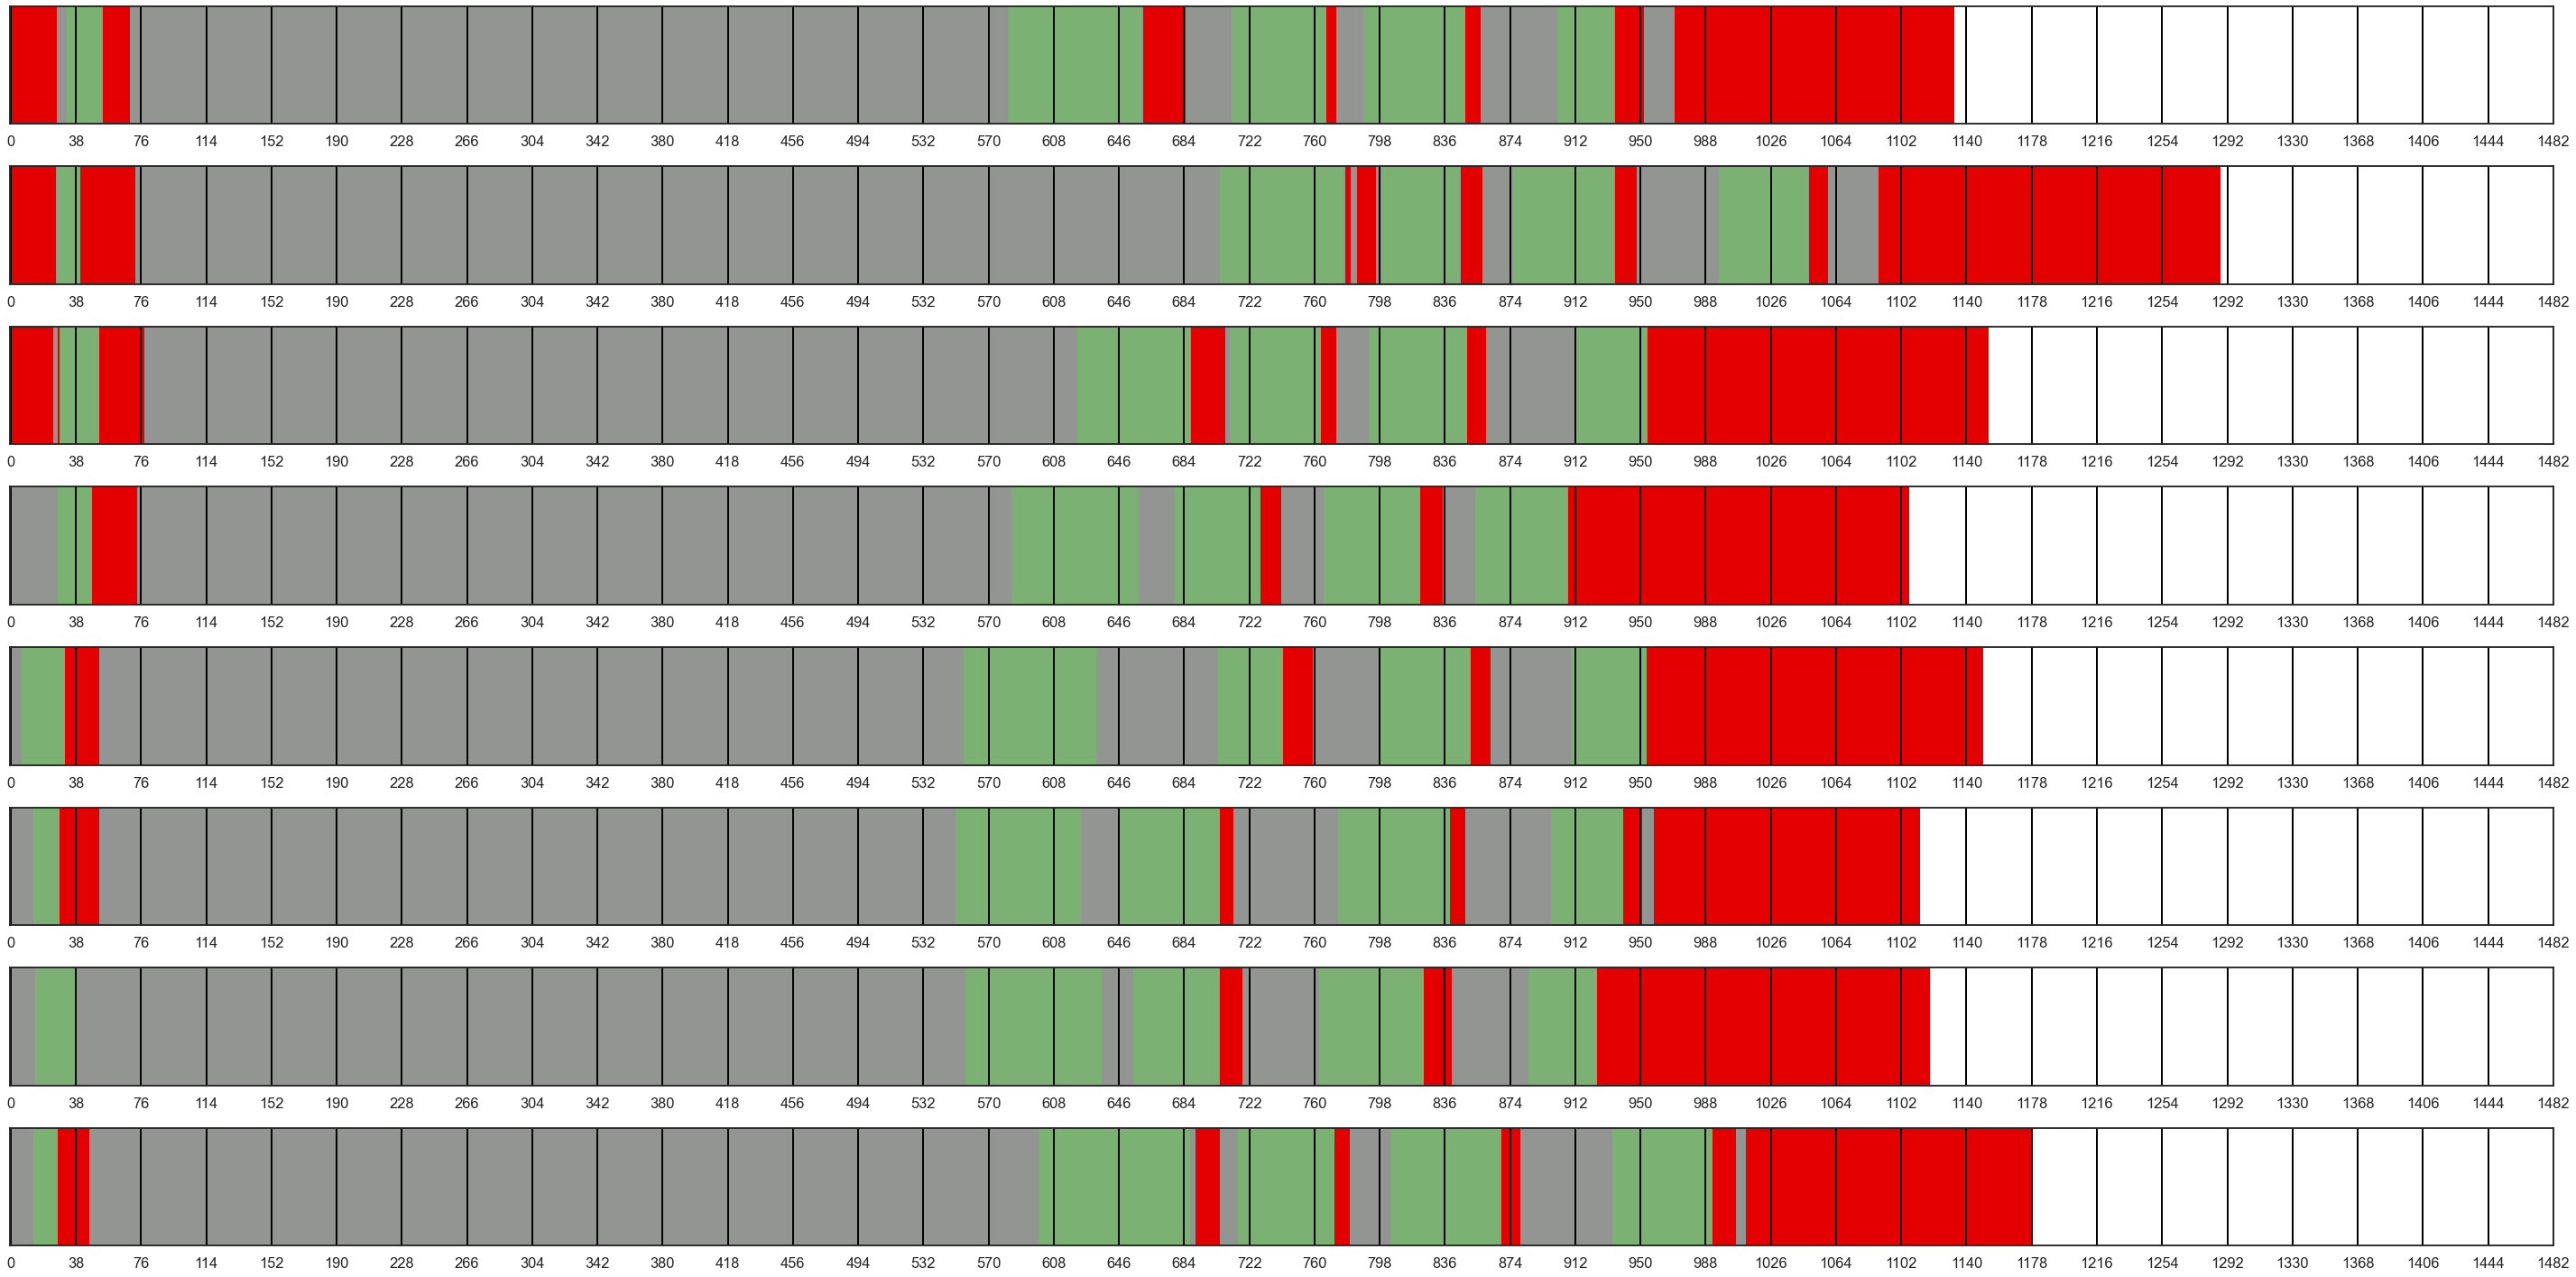

In [195]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
import os
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = [#"windows blue",
               "red",
               "grey",
               "faded green",
               "dusty purple",
#                "navajowhite",
    "sky blue",
#                "clay",
#                "pink",
#                "greyish",
#                "mint",
#                "cyan",
#                "steel blue",
#                "forest green",
    "light yellow",
#                "pastel purple",
               "light yellow",
               ]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)
cmap_limited = ListedColormap(colors[0:num_states])
NNN=8
Leng=np.load('leng.npy')
kmeans=np.load('sh.npy')

q_lem_z=kmeans[np.sum(Leng[:15]):]

Leng=Leng[15:]

print(np.sum(Leng[:15]))
# states_list=[q_lem_z[:100],q_lem_z[100:200],q_lem_z[200:300],q_lem_z[300:400],q_lem_z[400:500],q_lem_z[500:600],q_lem_z[600:700],q_lem_z[800:900]]
states_list=[q_lem_z[:Leng[0]],q_lem_z[Leng[0]:Leng[1]+Leng[0]],q_lem_z[Leng[1]+Leng[0]:Leng[1]+Leng[0]+Leng[2]],q_lem_z[Leng[1]+Leng[0]+Leng[2]:Leng[1]+Leng[0]+Leng[2]+Leng[3]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]],q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]+Leng[7]]]

x = np.arange(0,1500,1) # the grid to which your data corresponds
nx = x.shape[0]
no_labels = 40 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = x[::step_x] # labels you want to see

fig, axs = plt.subplots(8,1, figsize=(40,20))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_xticks(x_positions)
#     ax.set_xticks([])

    ax.grid(color='k', linestyle='-', linewidth=2)
#     ax.set_title(titles[i])
#     if i < (len(axs) - 1):
#         ax.set_xticks([])

# plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()


18851


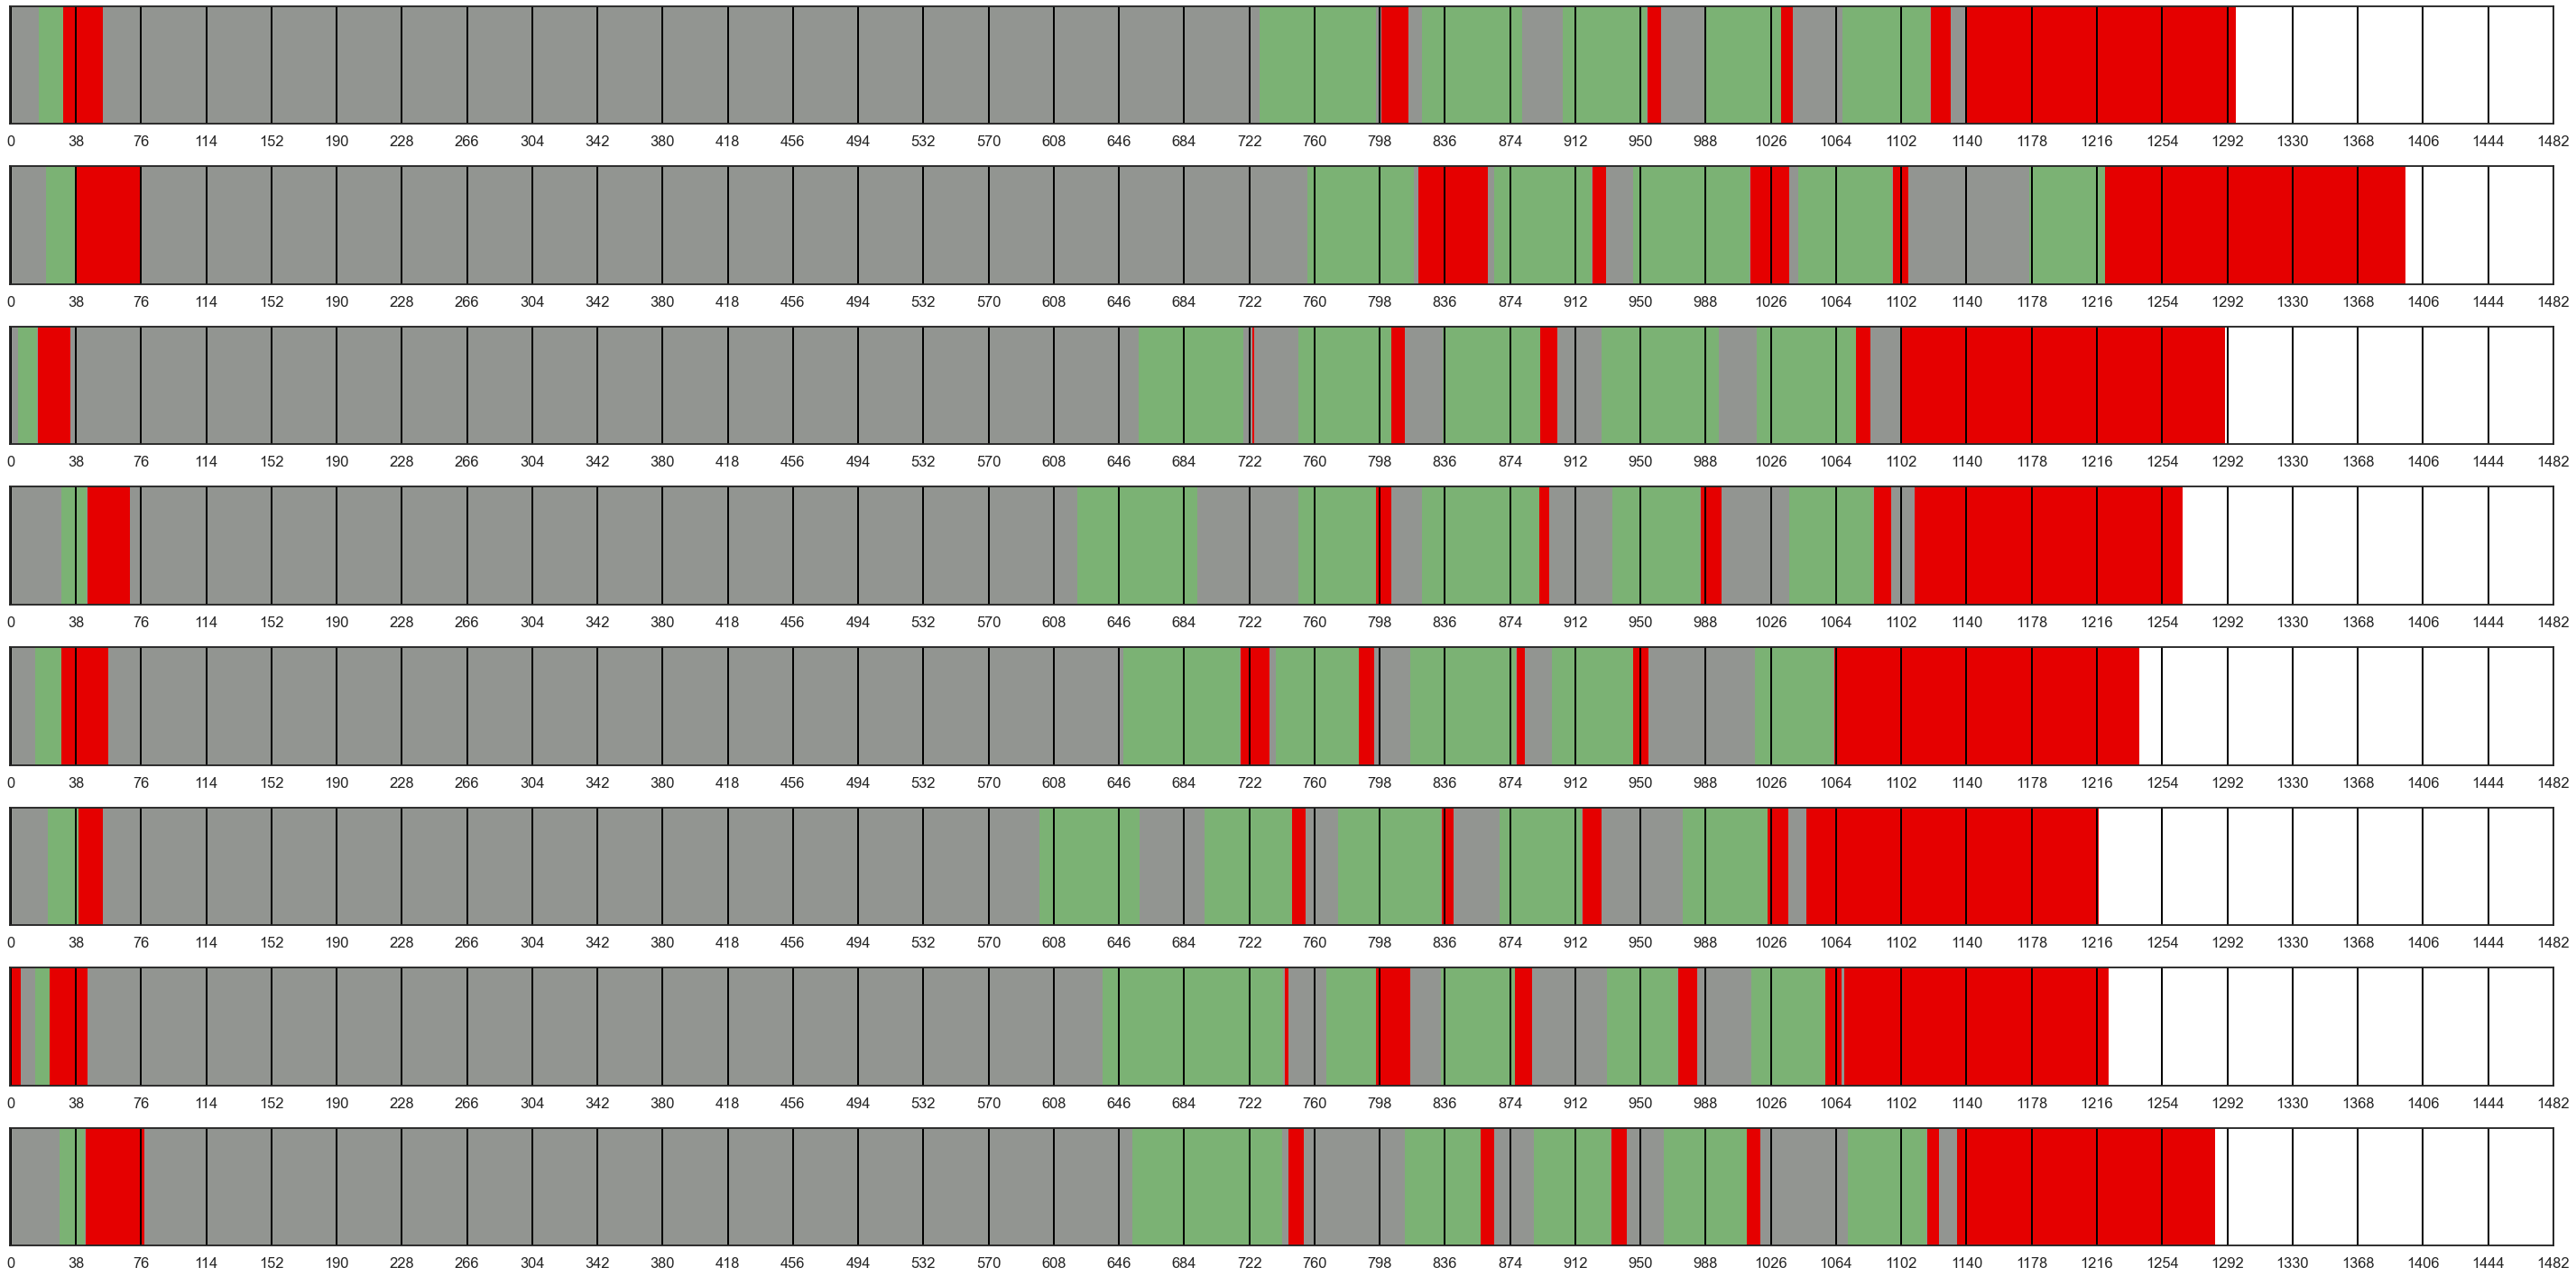

In [196]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
import os
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = [#"windows blue",
               "red",
               "grey",
               "faded green",
               "dusty purple",
#                "navajowhite",
    "sky blue",
#                "clay",
#                "pink",
#                "greyish",
#                "mint",
#                "cyan",
#                "steel blue",
#                "forest green",
    "light yellow",
#                "pastel purple",
               "light yellow",
               ]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)
cmap_limited = ListedColormap(colors[0:num_states])
NNN=8
Leng=np.load('leng.npy')
q_lem_z=kmeans[np.sum(Leng[:30]):]

Leng=Leng[30:]
kmeans=np.load('sh.npy')

print(np.sum(Leng[:30]))
# states_list=[q_lem_z[:100],q_lem_z[100:200],q_lem_z[200:300],q_lem_z[300:400],q_lem_z[400:500],q_lem_z[500:600],q_lem_z[600:700],q_lem_z[800:900]]
states_list=[q_lem_z[:Leng[0]],q_lem_z[Leng[0]:Leng[1]+Leng[0]],q_lem_z[Leng[1]+Leng[0]:Leng[1]+Leng[0]+Leng[2]],q_lem_z[Leng[1]+Leng[0]+Leng[2]:Leng[1]+Leng[0]+Leng[2]+Leng[3]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]],q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]],
             q_lem_z[Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]:Leng[1]+Leng[0]+Leng[2]+Leng[3]+Leng[4]+Leng[5]+Leng[6]+Leng[7]]]

x = np.arange(0,1500,1) # the grid to which your data corresponds
nx = x.shape[0]
no_labels = 40 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = x[::step_x] # labels you want to see

fig, axs = plt.subplots(8,1, figsize=(40,20))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_xticks(x_positions)
#     ax.set_xticks([])

    ax.grid(color='k', linestyle='-', linewidth=2)
#     ax.set_title(titles[i])
#     if i < (len(axs) - 1):
#         ax.set_xticks([])

# plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()


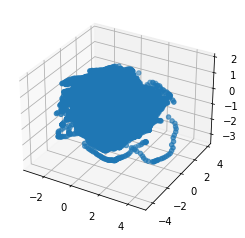

In [37]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ALL[:,0],ALL[:,1],ALL[:,2])
np.save('all_latent_10',ALL)